In [1]:
import numpy as np
import h5py
from copy import deepcopy
import os, zipfile, shutil,gzip
import pandas as pd
import glob
from scipy.stats import linregress
import os
from datetime import datetime
from datetime import timedelta
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
import scipy
from numpy import polyfit, poly1d
from scipy import interpolate
import matplotlib as mpl
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import time
from tqdm import tqdm
import math
import plotly
from plotly import graph_objs as go
from plotly.subplots import make_subplots

D:\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
secret='TD.a-ZsKkoLFWpWQpFK.dejlvOF7NK0XBVM.LlD63gOWm7VaNIu.WzC3t3XtgjavrVM.PxZSkA5B3pBRC2T.baP4'
import nest_asyncio
nest_asyncio.apply()
from tardis_dev import datasets
def download(ex,types,begin,end,coin):
    datasets.download(
            exchange=ex,
            data_types=[
                types
            ],
            from_date=begin,
            to_date=end,
            symbols=[coin],
            api_key=secret,
        )

In [4]:
begin = '2023-10-24'
end = '2020-10-25'
coin = 'USDT-USD'
download('kraken','trades',begin,end,coin)

#  研究各交易所的fp

In [11]:
begin = '2023-11-18'
end = '2023-11-19'
coin = 'LINK-USD'
coin1 = coin.replace('-','').replace('XBT', 'BTC').replace('USD', 'USDT')
coin2 = coin.replace('XBT', 'BTC').replace('USD', 'USDT')
def trade2clean(df):
    f = lambda x: datetime.fromtimestamp(x / 1000000)
    df['time'] = df['timestamp'].map(f)
    df = df[['time','side','price','amount']]
    return df
def level2fp(df1):
    df1['mp'] = (df1['asks[0].price'] + df1['bids[0].price']) / 2
    f_gettime = lambda x: datetime.fromtimestamp((x) / 1000000)  ##get datatime_type
    df1['time_ms'] = df1.timestamp.map(f_gettime)
    df1['time'] = df1['time_ms'].astype('datetime64[ms]')
    df1 = df1[['time', 'mp', 'bids[0].price', 'asks[0].price']]
    return df1
#download('kraken','trades',begin,end,coin)
download('binance-futures','book_snapshot_5',begin,end,coin1)
#download('okex','book_snapshot_5',begin,end,coin2)
#df = pd.read_csv(f'C:/Users/杜威/Desktop/datasets/kraken_trades_{begin}_{coin}.csv.gz')
#df = trade2clean(df)
dt = pd.read_csv(f'C:/Users/杜威/Desktop/datasets/binance-futures_book_snapshot_5_{begin}_{coin1}.csv.gz')
dt = level2fp(dt)
#dp = pd.read_csv(f'C:/Users/杜威/Desktop/datasets/okex_book_snapshot_5_{begin}_{coin2}.csv.gz')
#dp = level2fp(dp)

In [16]:
left = '2023-11-18 15:00:23'
right = '2023-11-18 15:00:55'
#df1 = df[df['time']>=left][df['time']<=right]
dt1 = dt[dt['time']>=left][dt['time']<=right]
#dp1 = dp[dp['time']>=left][dp['time']<=right]

C:\Users\杜威\AppData\Local\Temp/ipykernel_8588/3319869544.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dt1 = dt[dt['time']>=left][dt['time']<=right]


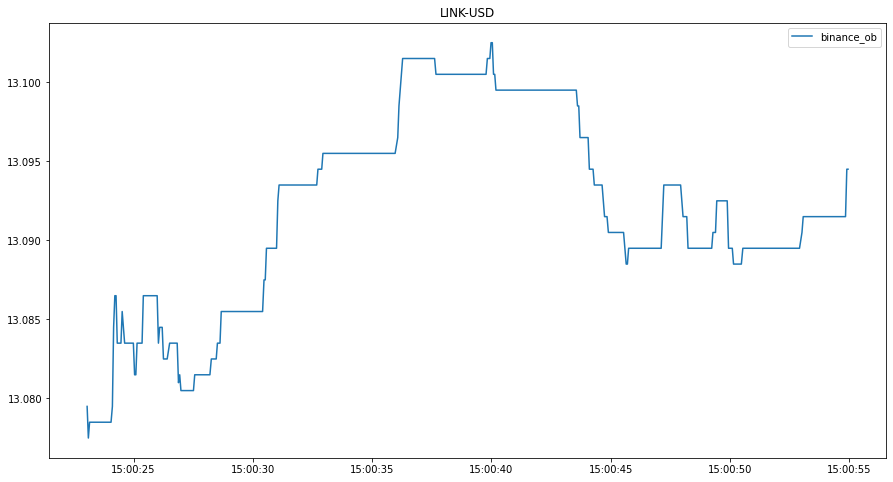

In [17]:
plt.figure(figsize=(15, 8))
#plt.plot(df1['time'],df1['price'],label = 'kraken_trade')
plt.plot(dt1['time'],dt1['mp'],label = 'binance_ob')
#plt.plot(dp1['time'],dp1['mp'],label = 'okex_ob')
plt.title(f'{coin}')
plt.legend()

#  各交易所交易量分布——流动性

In [18]:
begin = '2021-05-15'
end = '2021-10-16'
ex_ls = ['kraken', 'okex', 'okex-swap', 'binance', 'binance-futures', 'coinbase']
coin_ls = ['LINK-USDT','DOGE-USDT','LTC-USDT','XRP-USDT','ADA-USDT','SOL-USDT','MATIC-USDT','DOT-USDT','BTC-USDT','ETH-USDT']
def trade2clean(df):
    f = lambda x: datetime.fromtimestamp(x / 1000000)
    df['time'] = df['timestamp'].map(f).dt.floor('s')
    df['amount'] = df['amount'] * df['price']
    df = df[['time','side','amount']]
    return df
def get_trade(begin, end, ex, coin):
    dt = []
    for file in os.listdir(f'C:/Users/杜威/Desktop/datasets'):
        date = file[(len(ex) + 8):(len(ex) + 18)]
        if date >= begin and date <= end:
            df = pd.read_csv(f'C:/Users/杜威/Desktop/datasets/{ex}_trades_{date}_{coin}.csv.gz')
            df = trade2clean(df)
            dt.append(df)
    dt = pd.concat(dt)
    return dt
def get_s_trade(begin, end, ex, coin):
    dt = get_trade(begin, end, ex, coin)
    dt = dt.groupby(['time','side'],as_index = False).sum()
    dt = dt.sort_values(by = 'amount',ascending = False)
    dt['num'] = 1
    dt['pro'] = np.log(dt['num'].cumsum() / dt['num'].sum())
    return dt
def get_week_trade(begin, end, ex, coin):
    dt = get_trade(begin, end, ex, coin)
    dt = dt[(dt['time'] >= '2021-05-10') & (dt['time'] <= '2023-10-16')]
    df = dt.groupby(['side', pd.Grouper(key='time', freq='W')])['amount'].sum().reset_index().sort_values('time')
    return df

In [27]:
begin = '2021-05-15'
end = '2021-10-16'
ex_ls = ['kraken']
coin_ls = ['ETH-USDT']

In [26]:
def plotly_amount(ex_ls, coin_ls, begin, end):
    for ex in  ex_ls:
        # 创建图表
        layout = go.Layout(
            title=f'{ex}',
            xaxis=dict(title='Time'),
            yaxis=dict(title='Week Sum')
        )
        fig = go.Figure(layout=layout)
        for coin in coin_ls:
            if ex in ['kraken']:
                coin = coin.replace('USDT', 'USD').replace('DOGE', 'XDG').replace('BTC', 'XBT')
            elif ex == 'coinbase':
                coin = coin.replace('USDT', 'USD')
            elif ex in ['binance', 'binance-futures']:
                coin = coin.replace('-', '')
            elif ex == 'okex-swap':
                coin += '-SWAP'
            df = get_week_trade(begin, end, ex, coin)
            for side in ['buy', 'sell']:
                df1 = df[df['side'] == side]
                # 创建CDF曲线
                fig.add_trace(
                    go.Scatter(
                        x=df1['time'],
                        y=df1['amount'],
                        mode='lines',
                        name=f'{coin}_{side}'
                    )
                )
        plotly.offline.plot(fig, filename=f'{ex}.html', auto_open=False)

In [30]:
plotly_amount(ex_ls, coin_ls, begin, end)

In [8]:
def trade2clean(df, seq):
    f = lambda x: datetime.fromtimestamp(x / 1000000)
    df['time'] = df['timestamp'].map(f).dt.floor(seq)
    df['amount'] = df['amount'] * df['price']
    df = df[['time','amount']]
    df = df.groupby(['time'],as_index = False).sum()
    return df

def get_trade(begin, end, ex, coin, seq):
    dt = []
    for file in os.listdir(f'Y:/Trade Pro/data_wei/{ex}/trade/{coin}/datasets'):
        date = file[(len(ex) + 8):(len(ex) + 18)]
        if date >= begin and date <= end:
            df = pd.read_csv(f'Y:/Trade Pro/data_wei/{ex}/trade/{coin}/datasets/{ex}_trades_{date}_{coin}.csv.gz',
                             usecols = ['timestamp', 'amount', 'price'])
            df = trade2clean(df, seq)
            dt.append(df)
    dt = pd.concat(dt)
    return dt

def sum_df(df):
    dt = df[:]
    dt['time'] = pd.to_datetime(dt['time']).astype('datetime64[D]')
    dt = dt.groupby('time', as_index=False)['time'].sum()
    n = len(dt)
    df = df[df['amount'] > 0]
    df['log amount'] = np.log10(df['amount'])
    other_coin = df.groupby('log amount', as_index=False)['log amount'].agg(['count'])
    other_coin = other_coin.reset_index()
    other_coin1 = other_coin.iloc[1:, :]
    sum_count = other_coin1['count'].sum()
    other_coin1['amount'] = other_coin1['count']
    other_coin1 = other_coin1.reset_index()
    for i in range(1, len(other_coin1['amount'])):
        other_coin1['amount'][i] = other_coin1['amount'][i - 1] + other_coin1['amount'][i]
    other_coin1['prob_real'] = (sum_count - other_coin1['amount'] + 1) / n
    return other_coin1[['log amount', 'prob_real']]

def plotly_prob(ex_ls, coin_ls, begin, end):
    path = f'Y:/Trade Pro/data_wei/amount_trend/distribution'
    os.chdir(path)
    for coin in coin_ls:
        cc = coin[:-5]
        # 创建图表
        layout = go.Layout(
            title=f'{cc}:{begin}_{end}',
            xaxis=dict(title='Time'),
            yaxis=dict(title='Week Sum')
        )
        fig = go.Figure(layout=layout)
        for ex in tqdm(ex_ls):
            if ex in ['kraken']:
                coin1 = coin.replace('USDT', 'USD').replace('DOGE', 'XDG').replace('BTC', 'XBT')
            elif ex == 'coinbase':
                coin1 = coin.replace('USDT', 'USD')
            elif ex in ['binance', 'binance-futures']:
                coin1 = coin.replace('-', '')
            elif ex == 'okex-swap':
                coin1 = coin + '-SWAP'
            else:
                coin1 = coin
            df = get_trade(begin, end, ex, coin1, 'S')
            df = sum_df(df)
            x1, y1 = df['log amount'], np.log10(df['prob_real'])
            # 创建CDF曲线
            fig.add_trace(
                go.Scatter(
                    x= x1,
                    y= y1,
                    mode='lines',
                    name=f'{ex}'
                )
            )
        plotly.offline.plot(fig, filename=f'{cc}:{begin}_{end}.html', auto_open=False)

In [10]:
begin = '2023-10-01'
end = '2023-10-16'
ex_ls = ['kraken', 'okex', 'okex-swap', 'binance', 'binance-futures', 'coinbase'][:]
coin_ls = ['LINK-USDT','DOGE-USDT','LTC-USDT','XRP-USDT','ADA-USDT','DOT-USDT','BTC-USDT','ETH-USDT','SOL-USDT','MATIC-USDT'][:]
plotly_prob(ex_ls, coin_ls, begin, end)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [09:33<00:00, 95.64s/it]


OSError: [Errno 28] No space left on device

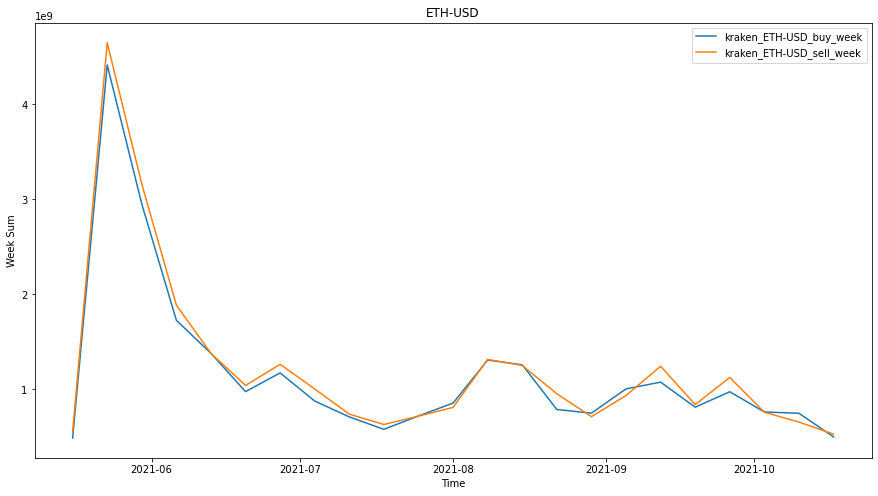

In [23]:
plt.figure(figsize=(15, 8))
for ex in  ex_ls:
    for coin in coin_ls:
        if ex in ['kraken']:
            coin = coin.replace('USDT', 'USD').replace('DOGE', 'XDG').replace('BTC', 'XBT')
        elif ex == 'coinbase':
            coin = coin.replace('USDT', 'USD')
        elif ex in ['binance', 'binance-futures']:
            coin = coin.replace('-', '')
        elif ex == 'okex-swap':
            coin += '-SWAP'
        df = get_week_trade(begin, end, ex, coin)
        for side in ['buy', 'sell']:
            df1 = df[df['side'] == side]
            plt.plot(df1['time'],df1['amount'],label = f'{ex}_{coin}_{side}_week')
plt.title(f'{coin}')
plt.xlabel('Time')
plt.ylabel('Week Sum')
plt.legend()
plt.show()

In [11]:
time_part = {
    'coinbase':['2023-05-15 09:00:00','2023-07-20 23:59:59'],
    'bitstamp':['2023-05-24 01:00:05','2023-07-20 23:59:59'],
    'kraken_1':['2023-04-04 00:00:00','2023-05-15 02:55:59'],
    'kraken_2':['2023-05-15 13:00:00','2023-07-20 23:59:59']
}

In [13]:
dict_name = begin_map
f = open(r'C:\Users\杜威\Desktop\tardis\balance\begin_map.txt','w')
f.write(str(dict_name))
f.close()

In [1]:
def load_text(name):
    f = open(f'C:/Users/杜威/Desktop/tardis/balance/{name}.txt','r')
    a = f.read()
    tt = eval(a)
    f.close()
    return tt
balance_map = load_text('balance_map')
begin_map = load_text('begin_map')
time_part = load_text('time_part')

In [3]:
balance_map = {
    'bitstamp':{
        'usd':90000,
        'usdc':50000,
        'usdt':60000,
        'eur':265923,
        'gbp':10000
    },
    'coinbase':{
        'dai':10000,
        'eur':30000,
        'gbp':10000,
        'usd':30000,
        'usdt':50000
    },
    'kraken_1':{
        'aud':38069,
        'btc':18,
        'cad':178185,
        'chf':109190,
        'dai':34338,
        'dot':13155,
        'eth':196,
        'eur':555823,
        'gbp':169334,
        'matic':97425,
        'paxg':16,
        'sol':7022,
        'usd':750000,
        'usdc':149067,
        'usdt':348652
    },
    'kraken_2':{
        'aud':20824,
        'btc':11,
        'cad':141123,
        'chf':37783,
        'dai':2947,
        'dot':7678,
        'eth':195,
        'eur':311350,
        'gbp':226798,
        'matic':61620,
        'paxg':2,
        'sol':4494,
        'usd':629776,
        'usdc':47912,
        'usdt':226984
    }
}

In [23]:
if 'b' not in df.columns:
    df['b'] = 2
df

,Type,Datetime,Account,Amount,Value,Rate,Fee,Sub Type,a,b
0,Market,"May. 25, 2023, 12:01 AM",Test,286.94926 USDT,266.77 EUR,0.92969 EUR,0.00534 EUR,Buy,1,2
1,Market,"May. 25, 2023, 12:01 AM",Test,80.83008 USDT,75.14 EUR,0.92961 EUR,0.00150 EUR,Buy,1,2
2,Market,"May. 25, 2023, 12:04 AM",AUTOTRADE,329.60977 USDT,306.47 EUR,0.92979 EUR,0.00613 EUR,Buy,1,2
3,Market,"May. 25, 2023, 12:04 AM",AUTOTRADE,4660.21345 USDT,4333.02 EUR,0.92979 EUR,0.08666 EUR,Buy,1,2
4,Market,"May. 25, 2023, 12:04 AM",Test 2,0.00246813 BTC,60.48 EUR,24503 EUR,0.00605 EUR,Buy,1,2
...,...,...,...,...,...,...,...,...,...,...
21390,Market,"May. 24, 2023, 11:25 PM",Test,335.85629 USDT,312.20 EUR,0.92955 EUR,0.00624 EUR,Buy,1,2
21391,Market,"May. 24, 2023, 11:28 PM",AUTOTRADE,2702.63 EUR,2907.33 USD,1.07574 USD,0.05815 USD,Sell,1,2
21392,Market,"May. 24, 2023, 11:28 PM",Test,999.95 EUR,1075.68 USD,1.07573 USD,0.02151 USD,Sell,1,2
21393,Market,"May. 24, 2023, 11:28 PM",AUTOTRADE,999.95 EUR,1075.69 USD,1.07574 USD,0.02151 USD,Sell,1,2


In [2]:
def load_df(ex):
    df = []
    for name in os.listdir(f'C:/Users/杜威/Desktop/tardis/trade/{ex}'):
        d0 = pd.read_csv(f'C:/Users/杜威/Desktop/tardis/trade/{ex}/{name}')
        df.append(d0)
    df = pd.concat(df)
    return df

In [3]:
def clean_df_bit(df):
    abstract = df[(df['Value'] == 'Subtraction') | (df['Value'] == 'Addition')]
    df = df[(df['Value'] != 'Subtraction') & (df['Value'] != 'Addition')]
    df = df[~df['Fee'].isna()]
    
    getcoin = lambda x:x[-3:] if x[-4:] not in ['USDT','USDC'] else x[-4:]
    getnum = lambda x:float(x[:-4]) if x[-4:] not in ['USDT','USDC'] else float(x[:-5])
    df['coin1'] = df['Amount'].map(getcoin)
    df['coin2'] = df['Value'].map(getcoin)
    df['Amount'] = df['Amount'].map(getnum)
    df['Value'] = df['Value'].map(getnum) + df['Fee'].map(getnum)
    df['price'] = df['Value']/df['Amount']
    df['pair'] = df['coin1'] + df['coin2']
    recite = lambda x: x.replace('Z', '').replace('XETH', 'ETH').replace('XXBT', 'XBT').replace('XBT', 'BTC').lower()
    df['pair'] = df['pair'].map(recite)
    df.rename(columns = {'Amount':'amount','Value':'value','Datetime':'time','Sub Type':'type'},inplace=True)
    df = df[['time','amount','value','price','type','pair','Account']]
    df['type'] = df['type'].map(lambda x:x.lower())
    df['time'] = pd.to_datetime(df['time'])
    df['time']=df['time']+timedelta(hours=8)#使用+8时间
    df = df.sort_values(by='time').reset_index()
    df = df.iloc[:,1:]
    return df[df['Account'] == 'AUTOTRADE'],df[df['Account'] == 'Test'],abstract

def clean_df_cb(df):
    df['total'] = abs(df['total']) + df['fee']
    df['price'] = df['total'] / df['size']
    df['side'] = df['side'].map(lambda x:x.lower())
    recite = lambda x: x.replace('-', '').lower()
    df['product'] = df['product'].map(recite)
    df['time'] = pd.to_datetime(df['created at'])
    df['time']=df['time']+timedelta(hours=8)#使用+8时间
    df = df.sort_values(by='time').reset_index()
    df = df.iloc[:,1:]
    df.rename(columns = {'side':'type','product':'pair','total':'value','size':'amount'},inplace = True)
    df = df[['time','amount','value','price','type','pair']]

def clean_df_kk(df):
    df['time'] = pd.to_datetime(df['time'])
    df['time']=df['time']+timedelta(hours=8)#使用+8时间
    df = df.sort_values(by='time').reset_index()
    df = df[['time','pair','type','price','vol','cost']]
    recite = lambda x: x.replace('Z', '').replace('XETH', 'ETH').replace('XXBT', 'XBT').replace('XBT', 'BTC').lower()
    df['pair'] = df['pair'].map(recite)
    df.rename(columns={'vol': 'amount', 'cost': 'value'}, inplace=True)
    return df    
    
clean_func = {
    'bitstamp':clean_df_bit,
    'coinbase':clean_df_cb,
    'kraken':clean_df_kk
}

In [ ]:
def into_trade(df,balance,begin):
    rows = df_all.columns
    fp_map = {}
    p = 0
    for t in rows:
        fp_map[t] = p
        p += 1
    df = df[(df['time']>=time_part[0]) & (df['time']<=time_part[1])]
    arr = df.to_numpy()
    trade_records = np.empty((len(arr), 15), dtype=object)
    for i in range(0, len(arr)):
        if arr[i][1][-4:] in ['usdt','usdc']:
            coin1,coin2 = arr[i][1][:-4],arr[i][1][-4:]
        else:
            coin1,coin2 = arr[i][1][:-3],arr[i][1][-3:]
            
        amount,value = arr[i][4],arr[i][5]
        price = arr[i][3] 
        fprice1 = arr[i][fp_map[coin1]]
        fprice2 = arr[i][fp_map[coin2]]
        
        if arr[i][2] == 'buy':
            buy_coin,sell_coin = coin1,coin2
            buy_num,sell_num = 1,2
            buy_amount,sell_amount = amount,value*-1
            margin = fprice1 - price * fprice2
        else:
            buy_coin,sell_coin = coin2,coin1
            buy_num,sell_num = 2,1
            buy_amount,sell_amount = value,amount*-1
            margin = price * fprice2 - fprice1
            
        buy_fp = arr[i][fp_map[buy_coin]]
        sell_fp = arr[i][fp_map[sell_coin]]
        
        buy_pos_begin = begin[buy_coin] - balance[buy_coin]
        sell_pos_begin = begin[sell_coin] - balance[sell_coin]
        begin[buy_coin] += buy_amount
        begin[sell_coin] += sell_amount
        buy_pos_end = begin[buy_coin] - balance[buy_coin]
        sell_pos_end = begin[sell_coin] - balance[sell_coin]

        trade_record = np.array([arr[i][0],buy_coin,buy_amount,buy_fp,buy_pos_begin,buy_pos_end,
                                 sell_coin,sell_amount,sell_fp,sell_pos_begin,sell_pos_end,margin,buy_num,sell_num,price])
        trade_records[i] = trade_record

    columns = ['time', 'buy_coin', 'buy_amount','buy_fp','buy_pos_begin','buy_pos_end',
               'sell_coin', 'sell_amount', 'sell_fp','sell_pos_begin','sell_pos_end','margin','buy_num','sell_num','price']
    trade_records_df = pd.DataFrame(trade_records, columns=columns)
    return trade_records_df

In [6]:
ex = 'kraken_formal'
df = load_df(ex)
df = clean_func['kraken'](df)

In [4]:
ex = 'bitstamp'
df = load_df(ex)
auto,test,abst = clean_func[ex](df)

In [5]:
dt=pd.read_csv(r'D:\杜威\Desktop\trading data\Bitstamp trades.csv')

In [9]:
df=[]
for name in os.listdir(r"D:\杜威\Desktop\trading data\bitstamp"):
    dt=pd.read_csv(f'D:/杜威/Desktop/trading data/bitstamp/{name}')
    df.append(dt)
df=pd.concat(df,axis = 0, ignore_index=True)

In [6]:
def cleandata(a):
    if a[-4:] =='EUR':
        b=a[0:-3]
    if a[-4:]!='EUR':
        b=a[0:-4]
    return b
def givepair(a,b):
    if a[-3:]=='EUR':
        c='EUR/'+b[-3:]
    if a[-4:]!='EUR':
        c=a[-4:]+'/'+b[-3:]
    return c

In [7]:
df=df[df['Type']=='Market']
df=df[df['Account']=='AUTOTRADE']
df['Datetime']=pd.to_datetime(df['Datetime']).astype('datetime64[s]')
df=df.rename(columns={'Datetime':'time','Sub Type':'type','Rate':'Price'})
df['Pair']=list(map(givepair,df.Amount,df.Value))
df['Amount']=list(map(cleandata,df.Amount))
df['Amount']=df['Amount'].map(lambda x: float(x))
df['Value']=df['Value'].map(lambda x: float(x[0:-3]))
df['Price']=df['Price'].map(lambda x: float(x[0:-3]))

In [118]:
EURUSD=pd.read_csv(r'D:\临时下载\all_eurusd_ib_latest.csv')
EURUSD['time']=EURUSD['date']
EURUSD=EURUSD[['time','close']]
EURUSD['time'] = EURUSD['time'].map(lambda x: x[0:-6])
EURUSD['time']=pd.to_datetime(EURUSD['time']).astype('datetime64[s]')
df=pd.merge(df,EURUSD,on='time',how='left')
df=df.rename(columns={'close':'EURUSD'})
USDT=pd.read_csv(r'D:\临时下载\ccrti_USDT.csv')
USDT['ccrti'][len(USDT)-2]=1
USDT=USDT.rename(columns={'ccrti':'USDT'})
USDT['time']=USDT['timestamp']
USDT=USDT[['time','USDT']]
USDT['time']=pd.to_datetime(USDT['time']).astype('datetime64[s]')
df=pd.merge(df,USDT,on='time',how='left')

In [119]:
df=df.ffill()

In [120]:
df['exchange']=0.1
df['ror']=0.1
df['gain']=0.1
for i in range(len(df)):
    if df['Pair'][i]=='USDC/USD':
        df['exchange'][i]=1
    if df['Pair'][i]=='USDT/USD':
        df['exchange'][i]=df['USDT'][i]
    if df['Pair'][i]=='USDC/EUR':
        df['exchange'][i]=1/df['EURUSD'][i]
    if df['Pair'][i]=='USDT/EUR':
        df['exchange'][i]=df['USDT'][i]/df['EURUSD'][i]
    if df['Pair'][i]==' EUR/USD':
        df['exchange'][i]=df['EURUSD'][i]
"""df['time']=pd.to_datetime(df['time']).astype('datetime64[h]')
for name in os.listdir(r'D:\杜威\Desktop\bitstamp stable\rp'):
    rp=pd.read_csv(f'D:/杜威/Desktop/bitstamp stable/rp/{name}')
    rp['time']=pd.to_datetime(rp['time']).astype('datetime64[s]')
    df=pd.merge(df,rp,on='time',how='left')
    df['rp']=df['rp'].ffill()
    df=df.rename(columns={'rp':name})
df['rp']=0.1
for name in os.listdir(r'D:\杜威\Desktop\bitstamp stable\rp'):
    pame=name.replace('-','/')
    pame=pame.replace('.csv','')
    df=df.rename(columns={name:pame})
for i in range(len(df)):
    name=df['Pair'][i]
    df['rp'][i]=df[name][i]
df['exchange']=df['exchange']*(1+df['rp']/10000)"""
for i in range(len(df)):
    if df['type'][i]=='Sell':
        df['ror'][i]=df['Price'][i]/df['exchange'][i]-1.00005
    if df['type'][i]=='Buy':
        df['ror'][i]=1-df['Price'][i]/df['exchange'][i]-0.00005
df['dv']=0.1
for i in range(len(df)):
    if df['Pair'][i]=='USDC/USD':
        df['gain'][i]=df['ror'][i]*df['Value'][i]
        df['dv'][i]=df['Value'][i]
    if df['Pair'][i]=='USDT/USD':
        df['gain'][i]=df['ror'][i]*df['Value'][i]
        df['dv'][i]=df['Value'][i]
    if df['Pair'][i]=='USDC/EUR':
        df['gain'][i]=df['ror'][i]*df['Amount'][i]
        df['dv'][i]=df['Amount'][i]
    if df['Pair'][i]=='USDT/EUR':
        df['gain'][i]=df['ror'][i]*df['Amount'][i]
        df['dv'][i]=df['Amount'][i]
    if df['Pair'][i]==' EUR/USD':
        df['gain'][i]=df['ror'][i]*df['Value'][i]
        df['dv'][i]=df['Value'][i]
    if df['Pair'][i]=='USDC-USDT':
        df['gain'][i]==df['ror'][i]*df['Value'][i]
        df['dv'][i]=df['Value'][i]

In [121]:
df['pair']=df['Pair']
df['side']=df['type']

In [122]:
def calculate(df):
    adf=[]
    buy=df[df['type']=='Buy']
    Sell=df[df['type']=='Sell']
    df_a = Sell.groupby(Sell['pair']).sum()
    df_b=buy.groupby(buy['pair']).sum()
    df_b['side']='buy'
    df_a['side']='sell'
    pf=df_b.append(df_a)[['side','dv','gain']]
    adf=pf
    for i in range(-30,40,5):
        pf=[]
        if i==-30:
            buy=df[df['type']=='Buy'][df['ror']<=(i/10000)]
            Sell=df[df['type']=='Sell'][df['ror']<=(i/10000)]
            df_a = Sell.groupby(Sell['pair']).sum()
            df_b=buy.groupby(buy['pair']).sum()
            df_b['side']='buy'
            df_a['side']='sell'
            pf=df_b.append(df_a)[['side','dv','gain']]
            name1='dv<%d'%i
            name2='gain<%d'%i
            pf=pf.rename(columns={'dv':name1,'gain':name2})
            adf=adf.merge(pf,on=['pair','side'],how='outer')
        if (i>-30) & (i<=30):
            buy=df[df['type']=='Buy'][df['ror']>((i-5)/10000)][df['ror']<=(i/10000)]
            Sell=df[df['type']=='Sell'][df['ror']>((i-5)/10000)][df['ror']<=(i/10000)]
            df_a = Sell.groupby(Sell['pair']).sum()
            df_b=buy.groupby(buy['pair']).sum()
            df_b['side']='buy'
            df_a['side']='sell'
            pf=df_b.append(df_a)[['side','dv','gain']]
            name1='dv%d'%i
            name2='gain%d'%i
            pf=pf.rename(columns={'dv':name1,'gain':name2})
            adf=adf.merge(pf,on=['pair','side'],how='outer')
        if i==35:
            buy=df[df['type']=='Buy'][df['ror']>((i-5)/10000)]
            Sell=df[df['type']=='Sell'][df['ror']>((i-5)/10000)]
            df_a = Sell.groupby(Sell['pair']).sum()
            df_b=buy.groupby(buy['pair']).sum()
            df_b['side']='buy'
            df_a['side']='sell'
            pf=df_b.append(df_a)[['side','dv','gain']]
            name1='dv>%d'%(i-5)
            name2='gain>%d'%(i-5)
            pf=pf.rename(columns={'dv':name1,'gain':name2})
            adf=adf.merge(pf,on=['pair','side'],how='outer')
    adf.loc['sum'] = adf.apply(lambda x: x.sum())
    adf['side'][-1]='NA'
    return adf
def sumday(df,circle): 
    dt=df
    dt['time']=pd.to_datetime(dt['time']).astype('datetime64[D]')
    dt=dt.groupby('time', as_index =False)['time'].sum()
    n=int(len(dt)/circle)
    return n

In [123]:
adf=calculate(df)
adf['time']='all'
adf.to_csv(r'D:\杜威\Desktop\收益率\bitstamp.csv')
timelim=datetime.strptime('2022-04-29','%Y-%m-%d')
df['time']=pd.to_datetime(df['time']).astype('datetime64[D]')
for i in range(sumday(df,7)):
    dt=df[df['time']>=timelim+timedelta(days=i*7)][df['time']<timelim+timedelta(days=(i+1)*7)]
    adf=calculate(dt)
    adf['time']=timelim+timedelta(days=i*7)
    adf.to_csv(r'D:\杜威\Desktop\收益率\bitstamp.csv',mode='a')

In [96]:
adf

,side,dv,gain,dv<-30,gain<-30,dv-25,gain-25,dv-20,gain-20,dv-15,...,dv15,gain15,dv20,gain20,dv25,gain25,dv30,gain30,dv>30,gain>30
pair,,,,,,,,,,,,,,,,,,,,,
EUR/USD,buy,9.393000e+02,939.300000,939.30000,939.300000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
USDC/EUR,buy,7.162302e+06,21858.017562,3764.31909,-14.472324,NaN,NaN,2549.08488,-5.945690,NaN,...,4.452827e+05,529.784857,3.321570e+05,563.908850,2.450908e+05,577.104472,1.953346e+05,557.344470,2.362623e+06,18298.860074
USDC/USD,buy,1.833502e+07,29480.885809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.232099e+05,1123.610596,9.633817e+05,1697.073960,6.158650e+05,1415.382446,1.090024e+06,2968.212764,4.240527e+06,22610.052576
USDT/EUR,buy,5.169375e+07,170095.157817,54279.10312,-202.734042,NaN,NaN,17836.98877,-39.804208,32034.06371,...,1.463406e+06,1777.829856,1.150421e+06,2038.218445,3.225153e+06,7282.667265,2.388116e+06,6602.840045,2.641154e+07,150890.613895
USDT/USD,buy,1.344076e+07,3350.001342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.305600e+04,64.932539,1.070929e+05,196.245320,7.673509e+04,174.008463,2.495160e+03,6.291111,5.968736e+05,2667.079594
EUR/USD,sell,1.480000e+03,1480.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.480000e+03,1480.000000
USDC/EUR,sell,8.587730e+06,1573.984176,49961.10817,-203.179934,124702.40317,-363.214812,20252.61656,-45.264580,3181.67994,...,2.774152e+05,332.928609,2.439361e+05,420.095314,2.192242e+05,478.261344,7.246148e+04,208.708775,1.107064e+05,573.795046
USDC/USD,sell,1.655031e+07,15897.003130,279399.04000,-1078.480294,NaN,NaN,NaN,NaN,NaN,...,6.702563e+05,877.509793,8.350875e+05,1523.283903,5.914003e+05,1302.450970,7.218932e+05,1952.960713,2.960870e+06,12868.828734
USDT/EUR,sell,5.586447e+07,4044.569445,3049.50449,-11.315984,92739.90800,-242.245902,51924.96447,-115.592016,142555.19885,...,2.198198e+06,2666.328470,1.139841e+06,1968.740679,1.124171e+05,256.650762,2.457718e+05,649.498361,9.154045e+05,3864.143794


In [34]:
df=[]
for name in os.listdir(r"D:\杜威\Desktop\trading data\bitstamp"):
    dt=pd.read_csv(f'D:/杜威/Desktop/trading data/bitstamp/{name}')
    df.append(dt)
df=pd.concat(df,axis = 0, ignore_index=True)

In [35]:
def cleandata(a):
    if a[-4:] =='EUR':
        b=a[0:-3]
    if a[-4:]!='EUR':
        b=a[0:-4]
    return b
def givepair(a,b):
    if a[-3:]=='EUR':
        c='EUR/'+b[-3:]
    if a[-4:]!='EUR':
        c=a[-4:]+'/'+b[-3:]
    return c

In [36]:
#df=df[df['Type']=='Market']
df=df[df['Account']=='AUTOTRADE']
df['Datetime']=pd.to_datetime(df['Datetime']).astype('datetime64[s]')
df=df.rename(columns={'Datetime':'time','Sub Type':'type','Rate':'Price'})
df['Pair']=list(map(givepair,df.Amount,df.Value))
df['Amount']=list(map(cleandata,df.Amount))
df['Amount']=df['Amount'].map(lambda x: float(x))
def clatype2(a,b):
    if b=='Subtraction':
        a=-a
        b=0
    elif b=='Addition':
        b=0
    return a
def clatype3(b):
    if b=='Subtraction':
        b='0NAN'
    elif b=='Addition':
        b='0NAN'
    return b
df['Amount']=list(map(clatype2,df.Amount,df.Value))
df['Value']=list(map(clatype3,df.Value))
df['Value']=df['Value'].map(lambda x: float(x[0:-3]))
df['Price']=df['Price'].fillna('0NAN')
df['Price']=df['Price'].map(lambda x: float(x[0:-3]))

In [37]:
def clatype1(a,b,c):
    if c=='Buy':
        b=-b*1.00005
    if c=='Sell':
        a=-a
        b=0.99995*b
    return a
def clatype2(a,b,c):
    if c=='Buy':
        b=-b*1.00005
    if c=='Sell':
        a=-a
        b=0.99995*b
    return b
df['Amount']=list(map(clatype1,df.Amount,df.Value,df.type))
df['Value']=list(map(clatype2,df.Amount,df.Value,df.type))

In [38]:
gain1=df[['time','Pair','Amount']]
gain1['asset']=gain1['Pair'].map(lambda x:x[0:-4] if x[0]!=' ' else x[1:4])
gain2=df[['time','Pair','Value']]
gain2['asset']=gain2['Pair'].map(lambda x:x[-3:])

In [39]:
def sumday(df,circle): 
    dt=df
    dt['time']=pd.to_datetime(dt['time']).astype('datetime64[D]')
    dt=dt.groupby('time', as_index =False)['time'].sum()
    n=int(len(dt)/circle)
    return n,dt

In [40]:
def getreset(df):
    day,time=sumday(df,1)
    day=day+1
    reset=pd.DataFrame(range(day))
    reset['time']='NAN'
    for name in ['EUR','USDC','USDT','USD']:
        reset[name]=0.1
        reset[name+'Value']=0.1
    timelim=datetime.strptime('2022-04-29 00:00:00','%Y-%m-%d %H:%M:%S')
    for i in range(1,day):
        dt=gain1
        dt=dt[dt['time']>=timelim+timedelta(days=i)]
        dt=dt[dt['time']<timelim+timedelta(days=(i+1))]
        dt=dt.groupby(dt['asset'],as_index=False).sum()
        dtt=gain2
        dtt=dtt[dtt['time']>=timelim+timedelta(days=i)]
        dtt=dtt[dtt['time']<timelim+timedelta(days=(i+1))]
        dtt=dtt.groupby(dtt['asset'],as_index=False).sum()
        reset['time'][i]=timelim+timedelta(days=i)
        for name in ['EUR','USDC','USDT']:
            try:
                reset[name][i]=dt[dt['asset']==name]['Amount']+reset[name][i-1]
            except:
                reset[name][i]=reset[name][i-1]
            reset=reset.ffill()
        for name in ['EUR']:
            try:
                reset[name][i]=dtt[dtt['asset']==name]['Value']+reset[name][i]
            except:
                reset[name][i]=reset[name][i]
        for name in ['USD']:
            try:
                reset[name][i]=dtt[dtt['asset']==name]['Value']+reset[name][i-1]
            except:
                reset[name][i]=reset[name][i-1]
    return reset

In [41]:
reset=getreset(df)

In [42]:
reset['time']=pd.to_datetime(reset['time']).astype('datetime64[D]')

In [43]:
dff=df[df['Type']=='Sub Account Transfer']

In [12]:
dff

,Type,time,Account,Amount,Value,Price,Fee,type,Pair
3929,Sub Account Transfer,2022-05-06,AUTOTRADE,-100.00000,0.0,0.0,NaN,NaN,USD/ion
29755,Sub Account Transfer,2022-06-02,AUTOTRADE,-1000.00000,0.0,0.0,NaN,NaN,EUR/ion
29756,Sub Account Transfer,2022-06-02,AUTOTRADE,-1000.00000,0.0,0.0,NaN,NaN,EUR/ion
29757,Sub Account Transfer,2022-06-02,AUTOTRADE,-1000.00000,0.0,0.0,NaN,NaN,USDT/ion
29758,Sub Account Transfer,2022-06-02,AUTOTRADE,-2500.00000,0.0,0.0,NaN,NaN,EUR/ion
29759,Sub Account Transfer,2022-06-02,AUTOTRADE,-2700.00000,0.0,0.0,NaN,NaN,USD/ion
29760,Sub Account Transfer,2022-06-02,AUTOTRADE,-1200.00000,0.0,0.0,NaN,NaN,USDC/ion
38586,Sub Account Transfer,2022-06-13,AUTOTRADE,-566330.94986,0.0,0.0,NaN,NaN,USDC/ion
38587,Sub Account Transfer,2022-06-13,AUTOTRADE,66310.94986,0.0,0.0,NaN,NaN,USDC/ion
38650,Sub Account Transfer,2022-06-13,AUTOTRADE,499980.00000,0.0,0.0,NaN,NaN,USDT/ion


In [44]:
    day,time=sumday(dff,1)
    day=day+1
    daw=pd.DataFrame(range(day))
    daw['time']='NAN'
    for name in [' EUR','USDC','USDT',' USD']:
        daw[name]=0.1
        daw[name+'Value']=0.1
    for i in range(1,day):
        dt=dff
        dt=dt[dt['time']==time['time'][i-1]]
        dt=dt.groupby(dt['Pair'],as_index=False).sum()
        daw['time'][i]=time['time'][i-1]
        for name in [' EUR','USDC','USDT',' USD']:
            try:
                daw[name][i]=dt[dt['Pair']==name+'/ion']['Amount']
            except:
                daw[name][i]=0
    daw=daw.fillna(0)

In [45]:
daw['time']=pd.to_datetime(daw['time']).astype('datetime64[D]')

In [33]:
reset

,0,time,EUR,EURValue,USDC,USDCValue,USDT_x,USDTValue,USD,USDValue,USDT_y,EURUSD,Total Value,Total Value-1D,gain,Deposit and withdrawal,gain_final
0,0,NaT,451062.095041,NaN,874274.37836,874274.37836,315736.69286,NaN,514814.888394,514814.888394,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,1,2022-04-30,798436.253843,NaN,813617.43478,813617.43478,160611.40698,160620.050765,364806.453866,364806.453866,1.000054,NaN,NaN,NaN,NaN,0.0,NaN
2,2,2022-05-01,368151.142307,388212.999355,829200.75114,829200.75114,356716.44184,356743.945539,606869.733851,606869.733851,1.000077,1.054494,2.181027e+06,NaN,NaN,0.0,NaN
3,3,2022-05-02,476473.432947,501202.842138,845048.66506,845048.66506,293524.60543,293508.128830,540965.767651,540965.767651,0.999944,1.051901,2.180725e+06,2.181027e+06,-302.026206,0.0,909.471563
4,4,2022-05-03,520814.836051,548033.011669,849956.24028,849956.24028,303502.94898,303465.538940,483372.954537,483372.954537,0.999877,1.052261,2.184828e+06,2.180725e+06,4102.341747,0.0,3961.228872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,125,2022-09-01,575388.211770,574730.325002,999569.61343,999569.61343,450202.03506,450330.229238,336243.066384,336243.066384,1.000285,0.998857,2.360873e+06,2.361768e+06,-895.253931,0.0,902.439934
126,126,2022-09-02,757606.042484,755994.194818,967588.80565,967588.80565,221216.13158,221279.122455,419114.168967,419114.168967,1.000285,0.997872,2.363976e+06,2.360873e+06,3103.057837,0.0,3546.981740
127,127,2022-09-03,749309.883683,747715.686541,995036.58860,995036.58860,171261.84866,171310.615148,451475.111724,451475.111724,1.000285,0.997872,2.365538e+06,2.363976e+06,1561.710122,0.0,1561.710122
128,128,2022-09-04,887886.560000,880886.360647,887886.56000,887886.56000,205994.83540,206053.492040,385406.790000,385406.790000,1.000285,0.992116,2.360233e+06,2.365538e+06,-5304.799325,0.0,-2708.233576


In [21]:
daw

,0,time,EUR,EURValue,USDC,USDCValue,USDT,USDTValue,USD,USDValue
0,0,NaT,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
1,1,2022-05-06,0.0,0.1,0.0,0.1,0.0,0.1,-100.0,0.1
2,2,2022-06-02,-4500.0,0.1,-1200.0,0.1,-1000.0,0.1,-2700.0,0.1
3,3,2022-06-13,0.0,0.1,-500020.0,0.1,499980.0,0.1,0.0,0.1
4,4,2022-08-20,0.0,0.1,0.0,0.1,-10000.0,0.1,0.0,0.1


In [46]:
USDT=pd.read_csv(r'D:\临时下载\ccrti_USDT.csv')
USDT['ccrti'][len(USDT)-2]=1
USDT=USDT.rename(columns={'ccrti':'USDT'})
USDT['time']=USDT['timestamp']
USDT=USDT[['time','USDT']]
USDT['time']=pd.to_datetime(USDT['time']).astype('datetime64[D]')
USDT=USDT.groupby(USDT['time']).mean()
reset=pd.merge(reset,USDT,on='time',how='left')
daw=pd.merge(daw,USDT,on='time',how='left')
for name in ['EURUSD']:
    pame=name.lower()
    dt=pd.read_csv(f'D:/临时下载/all_{pame}_ib_latest.csv')
    dt['time']=dt['date']
    dt=dt[['time','close']]
    dt['time']=dt['time'].map(lambda x: x[0:-6])
    dt['time']=pd.to_datetime(dt['time']).astype('datetime64[D]')
    dt=dt.groupby(dt['time']).mean()
    reset=pd.merge(reset,dt,on='time',how='left')
    daw=pd.merge(daw,dt,on='time',how='left')
    reset=reset.rename(columns={'close':f'{name}'})
    daw=daw.rename(columns={'close':f'{name}'})

In [47]:
reset=reset.ffill()
daw=daw.ffill()

In [48]:
end_USD=385406.79
end_EUR=887886.56
end_USDC=189461.6975
end_USDT=205994.8354
reset['EUR']=reset['EUR']+end_EUR-reset['EUR'][len(reset)-2]
reset['USD']=reset['USD']+end_USD-reset['USD'][len(reset)-2]
reset['USDC']=reset['USDC']+end_USDC-reset['USDC'][len(reset)-2]
reset['USDT_x']=reset['USDT_x']+end_USDT-reset['USDT_x'][len(reset)-2]

In [49]:
reset['USDCValue']=reset['USDC']
reset['USDTValue']=reset['USDT_x']*reset['USDT_y']
reset['EURValue']=reset['EUR']*reset['EURUSD']
reset['USDValue']=reset['USD']
daw['USDCValue']=daw['USDC']
daw['USDTValue']=daw['USDT_x']*daw['USDT_y']
daw[' EURValue']=daw[' EUR']*daw['EURUSD']
daw[' USDValue']=daw[' USD']

In [50]:
reset['Total Value']=reset['USDValue']+reset['EURValue']+reset['USDCValue']+reset['USDTValue']
reset['Total Value-1D']=reset['Total Value'].shift()
reset['gain']=reset['Total Value']-reset['Total Value-1D']
daw['Total_Value']=daw[' USDValue']+daw[' EURValue']+daw['USDCValue']+daw['USDTValue']

In [51]:
reset=pd.merge(reset,daw[['time','Total_Value']],on='time',how='left')
reset['Total_Value']=reset['Total_Value'].fillna(0)
reset=reset.rename(columns={'Total_Value':'Deposit and withdrawal'})

In [52]:
reset['gain_final']=reset['gain']-reset['Deposit and withdrawal']

In [53]:
reset2=reset[['time','EUR','EURUSD','EURValue','USDC','USDCValue','USDT_x','USDT_y','USDTValue','USD','USDValue',
             'Total Value','Deposit and withdrawal','gain','gain_final']]

In [54]:
daw2=daw[['time',' EUR','EURUSD',' EURValue','USDC','USDCValue','USDT_x','USDT_y','USDTValue',' USD',' USDValue',
             'Total_Value']]

In [55]:
reset2

,time,EUR,EURUSD,EURValue,USDC,USDCValue,USDT_x,USDT_y,USDTValue,USD,USDValue,Total Value,Deposit and withdrawal,gain,gain_final
0,NaT,451062.095041,NaN,NaN,175849.51586,175849.51586,315736.69286,NaN,NaN,514814.888394,514814.888394,NaN,0.0,NaN,NaN
1,2022-04-30,798436.253843,NaN,NaN,115192.57228,115192.57228,160611.40698,1.000054,160620.050765,364806.453866,364806.453866,NaN,0.0,NaN,NaN
2,2022-05-01,368151.142307,1.054494,388212.999355,130775.88864,130775.88864,356716.44184,1.000077,356743.945539,606869.733851,606869.733851,1.482603e+06,0.0,NaN,NaN
3,2022-05-02,476473.432947,1.051901,501202.842138,146623.80256,146623.80256,293524.60543,0.999944,293508.128830,540965.767651,540965.767651,1.482301e+06,0.0,-302.026206,-302.026206
4,2022-05-03,520814.836051,1.052261,548033.011669,151531.37778,151531.37778,303502.94898,0.999877,303465.538940,483372.954537,483372.954537,1.486403e+06,0.0,4102.341747,4102.341747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,2022-09-01,575388.211770,0.998857,574730.325002,301144.75093,301144.75093,450202.03506,1.000285,450330.229238,336243.066384,336243.066384,1.662448e+06,0.0,-895.253931,-895.253931
126,2022-09-02,757606.042484,0.997872,755994.194818,269163.94315,269163.94315,221216.13158,1.000285,221279.122455,419114.168967,419114.168967,1.665551e+06,0.0,3103.057837,3103.057837
127,2022-09-03,749309.883683,0.997872,747715.686541,296611.72610,296611.72610,171261.84866,1.000285,171310.615148,451475.111724,451475.111724,1.667113e+06,0.0,1561.710122,1561.710122
128,2022-09-04,887886.560000,0.992116,880886.360647,189461.69750,189461.69750,205994.83540,1.000285,206053.492040,385406.790000,385406.790000,1.661808e+06,0.0,-5304.799325,-5304.799325


In [57]:
reset2[2:-1].to_csv(r'D:\杜威\Desktop\资产\bitstamp资产.csv')
daw2[1:].to_csv(r'D:\杜威\Desktop\资产\bitstamp存取款.csv')